In [1]:
!set PYTHONPATH=D:\SharedLinux_D\CPSC_597\Object_Detection_Expressions\research;D:\SharedLinux_D\CPSC_597\Object_Detection_Expressions\research\slim

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import keras
from keras.models import load_model
from keras import backend as K
import xml.etree.ElementTree as ET
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [3]:
%matplotlib inline

In [14]:
# turn off tensorflow INFO (Debugging info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# append object_detection dir
sys.path.append("research/object_detection/..")
from object_detection.utils import ops as utils_ops
# od imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

OD_PATH = 'research/object_detection/'

In [5]:
# FUNCTIONS
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [6]:
# Additional Functions
def one_hot_encode_to_char(arr, threshold=0.5, get_max=True):
    result = []
    val = 0
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((val, arr[i]))
        val +=1
    _max = []
    high = 0
    if get_max:
        for i in result:
            if i[1] > high:
                _max = [i[0]]
                high = i[1]
        return _max
    else:
        return [i[0] for i in result]


def one_hot_encode_to_char_list(arr, threshold=0.5, get_max=True):
    result = []
    for i in range(len(arr)):
        if arr[i] >= threshold:
            result.append((i, arr[i]))
    _max = []
    high = 0
    result = sorted(result, key=lambda x: x[1], reverse=True)
    if get_max:
        return result[-1]
    return result

In [7]:
# Metrics

# read xml file
def read_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    all_boxes = []
    for i in root.iter('object'):
        ymin, xmin, ymax, xmax = None, None, None, None
        for j in i.findall("bndbox"):
            ymin = int(j.find("ymin").text)
            xmin = int(j.find("xmin").text)
            ymax = int(j.find("ymax").text)
            xmax = int(j.find("xmax").text)
        # bbox = [xmin, xmax, ymin, ymax]
        bbox = {
            'x1':xmin,
            'x2':xmax,
            'y1':ymin,
            'y2':ymax
        }
        all_boxes.append(bbox)
    return all_boxes

# calculate iou
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def calculate_map(map_data):
    """
    map_data: a list of tuples with each tuple containing (precision, recall)
    """
    md = sorted(map_data, key=lambda x:x[1])
    md = [(i, round(j, 1)) for i, j in md]
    ap_11_precs = {str(round(k*0.1, 1)):None for k in range(11)}

    for p_, r_ in md:
        if not ap_11_precs[str(r_)] or p_ > ap_11_precs[str(r_)]:
            ap_11_precs[str(r_)] =  p_
            
    ap_11_precs_list = list(ap_11_precs.values())
    ap_11_precs_list = [z if z != None else 0 for z in ap_11_precs_list]
    mean_ap = np.mean(ap_11_precs_list)
    return mean_ap


In [8]:
# VARIABLES
MODEL_NAME = 'trained_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OD_PATH + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OD_PATH + "training/data/object-detection.pbtxt"

In [9]:
# Load tf model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


In [10]:
# Load label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [11]:
# DETECTION
PATH_TO_TEST_IMAGES_DIR = OD_PATH + "training/test/*.png"
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
print("Test Image paths: ")
for i in TEST_IMAGE_PATHS:
    print(i)

Test Image paths: 
research/object_detection/training/test\exp0015.png
research/object_detection/training/test\exp0016.png
research/object_detection/training/test\exp0029.png
research/object_detection/training/test\exp0037.png
research/object_detection/training/test\exp0044.png
research/object_detection/training/test\exp0051.png
research/object_detection/training/test\exp9.png


In [12]:
IMAGE_SIZE = (320, 320)

# Load cnn model and labels
models_path = "../trained_models/"
#cnn = load_model(models_path+"hasyv2model31.h5")
#cnn = load_model(models_path+"hasyv2model51.h5")
cnn = load_model(models_path+"model3.h5")
#ann = load_model(models_path+"ann1.h5")
symbols = pd.read_csv("../processed_data/symbols.csv").drop(["Unnamed: 0"], axis=1)
symbols.head()

,latex,old_symbol,new_id
0,A,31,0
1,B,32,1
2,C,33,2
3,D,34,3
4,E,35,4


#### Note: Theres no data for `=` symbol in HASYv2 dataset. Therefore the predictions for `=` are all incorrect.

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp0015.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.44304729  xmin:  0.62258977  ymax:  0.5346477  xmax  0.70398235
left:  199.2287254333496  right:  225.27435302734375  top:  141.77513122558594  bottom  171.08726501464844
Top left point: ( 199 ,  141 ) and Bottom right point: ( 225 ,  171 )
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 93.27 %
Symbol_id: 0 , Latex: A , Confidence Score: 2.19 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.97 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.06 %


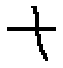

***************
Box: 
ymin:  0.4452551  xmin:  0.4039968  ymax:  0.5408191  xmax  0.5102667
left:  129.27897453308105  right:  163.28535079956055  top:  142.48163223266602  bottom  173.06211471557617
Top left point: ( 129 ,  142 ) and Bottom right point: ( 163 ,  173 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 93.76 %
Symbol_id: 79 , Latex: > , Confidence Score: 4.14 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.77 %


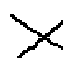

***************
Box: 
ymin:  0.4404138  xmin:  0.80491066  ymax:  0.536895  xmax  0.8992754
left:  257.5714111328125  right:  287.7681350708008  top:  140.93241691589355  bottom  171.80639266967773
Top left point: ( 257 ,  140 ) and Bottom right point: ( 287 ,  171 )
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 49.88 %
Symbol_id: 24 , Latex: Y , Confidence Score: 45.66 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.84 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 1.12 %


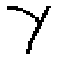

***************
Box: 
ymin:  0.45306078  xmin:  0.04506327  ymax:  0.55523604  xmax  0.13326716
left:  14.420245885848999  right:  42.64549255371094  top:  144.97944831848145  bottom  177.67553329467773
Top left point: ( 14 ,  144 ) and Bottom right point: ( 42 ,  177 )
CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 53.85 %
Symbol_id: 94 , Latex: \div , Confidence Score: 26.03 %
Symbol_id: 61 , Latex: z , Confidence Score: 8.08 %
Symbol_id: 99 , Latex: [ , Confidence Score: 7.5 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.53 %


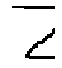

***************
Box: 
ymin:  0.48963553  xmin:  0.058787134  ymax:  0.56036156  xmax  0.1593941
left:  18.811882734298706  right:  51.00611209869385  top:  156.68336868286133  bottom  179.31570053100586
Top left point: ( 18 ,  156 ) and Bottom right point: ( 51 ,  179 )
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 68.54 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 14.94 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 10.88 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.35 %


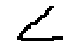

true {'x1': 14, 'x2': 60, 'y1': 142, 'y2': 179}
pred {'x1': 14.420245885848999, 'x2': 42.64549255371094, 'y1': 144.97944831848145, 'y2': 177.67553329467773}
IOU : 0.5422180161730406
---------------
true {'x1': 130, 'x2': 178, 'y1': 142, 'y2': 177}
pred {'x1': 129.27897453308105, 'x2': 163.28535079956055, 'y1': 142.48163223266602, 'y2': 173.06211471557617}
IOU : 0.5980332550179791
---------------
true {'x1': 195, 'x2': 230, 'y1': 139, 'y2': 175}
pred {'x1': 199.2287254333496, 'x2': 225.27435302734375, 'y1': 141.77513122558594, 'y2': 171.08726501464844}
IOU : 0.605915016393059
---------------
true {'x1': 256, 'x2': 284, 'y1': 136, 'y2': 170}
pred {'x1': 257.5714111328125, 'x2': 287.7681350708008, 'y1': 140.93241691589355, 'y2': 171.80639266967773}
IOU : 0.6883169414797192
---------------
{'TP': 4, 'FP': 0, 'TN': 0, 'FN': 1}
Precision:  1.0
Recall:  0.8


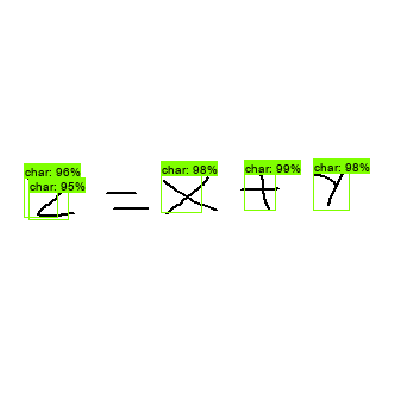

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp0016.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.45549616  xmin:  0.39957836  ymax:  0.5610104  xmax  0.49457017
left:  127.86507606506348  right:  158.26245307922363  top:  145.7587718963623  bottom  179.52333450317383
Top left point: ( 127 ,  145 ) and Bottom right point: ( 158 ,  179 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.9 %


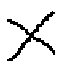

***************
Box: 
ymin:  0.45049435  xmin:  0.61130613  ymax:  0.53521544  xmax  0.70566267
left:  195.61796188354492  right:  225.81205368041992  top:  144.1581916809082  bottom  171.26893997192383
Top left point: ( 195 ,  144 ) and Bottom right point: ( 225 ,  171 )
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 98.21 %


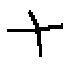

***************
Box: 
ymin:  0.45138666  xmin:  0.8003131  ymax:  0.5828865  xmax  0.902547
left:  256.1001968383789  right:  288.8150405883789  top:  144.4437313079834  bottom  186.52368545532227
Top left point: ( 256 ,  144 ) and Bottom right point: ( 288 ,  186 )
CNN/ANN Predictions:
Symbol_id: 24 , Latex: Y , Confidence Score: 40.72 %
Symbol_id: 60 , Latex: y , Confidence Score: 29.22 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.93 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.58 %
Symbol_id: 106 , Latex: //) , Confidence Score: 3.41 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.17 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.33 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.1 %


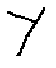

***************
Box: 
ymin:  0.4573914  xmin:  0.039210003  ymax:  0.5648978  xmax  0.13468935
left:  12.547200918197632  right:  43.10059070587158  top:  146.3652515411377  bottom  180.7672882080078
Top left point: ( 12 ,  146 ) and Bottom right point: ( 43 ,  180 )
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 36.86 %
Symbol_id: 9 , Latex: J , Confidence Score: 20.12 %
Symbol_id: 25 , Latex: Z , Confidence Score: 16.0 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 12.4 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.11 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.29 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.92 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.58 %


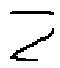

true {'x1': 14, 'x2': 62, 'y1': 148, 'y2': 186}
pred {'x1': 12.547200918197632, 'x2': 43.10059070587158, 'y1': 146.3652515411377, 'y2': 180.7672882080078}
IOU : 0.4962383239456888
---------------
true {'x1': 126, 'x2': 161, 'y1': 148, 'y2': 182}
pred {'x1': 127.86507606506348, 'x2': 158.26245307922363, 'y1': 145.7587718963623, 'y2': 179.52333450317383}
IOU : 0.7616292604855752
---------------
true {'x1': 188, 'x2': 235, 'y1': 144, 'y2': 178}
pred {'x1': 195.61796188354492, 'x2': 225.81205368041992, 'y1': 144.1581916809082, 'y2': 171.26893997192383}
IOU : 0.5122555835925519
---------------
true {'x1': 251, 'x2': 288, 'y1': 144, 'y2': 184}
pred {'x1': 256.1001968383789, 'x2': 288.8150405883789, 'y1': 144.4437313079834, 'y2': 186.52368545532227}
IOU : 0.7912187423092654
---------------
{'TP': 7, 'FP': 1, 'TN': 0, 'FN': 2}
Precision:  0.875
Recall:  0.7777777777777778


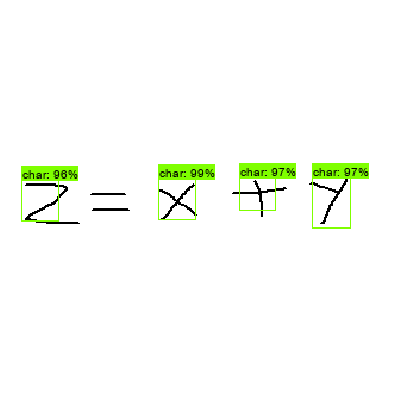

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp0029.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.34439418  xmin:  0.48200783  ymax:  0.44109932  xmax  0.58014935
left:  154.24250602722168  right:  185.6477928161621  top:  110.20613670349121  bottom  141.15178108215332
Top left point: ( 154 ,  110 ) and Bottom right point: ( 185 ,  141 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.66 %


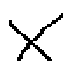

***************
Box: 
ymin:  0.3407044  xmin:  0.049480762  ymax:  0.4609799  xmax  0.15277235
left:  15.83384394645691  right:  48.887152671813965  top:  109.02541160583496  bottom  147.51357078552246
Top left point: ( 15 ,  109 ) and Bottom right point: ( 48 ,  147 )
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 73.63 %
Symbol_id: 90 , Latex: \% , Confidence Score: 6.04 %
Symbol_id: 59 , Latex: x , Confidence Score: 5.14 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 3.44 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.37 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.61 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.03 %


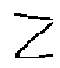

***************
Box: 
ymin:  0.35264978  xmin:  0.87456894  ymax:  0.45158872  xmax  0.9479117
left:  279.862060546875  right:  303.33173751831055  top:  112.84792900085449  bottom  144.50839042663574
Top left point: ( 279 ,  112 ) and Bottom right point: ( 303 ,  144 )
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 82.92 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 4.74 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 3.83 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 2.7 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.36 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.05 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.05 %


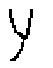

***************
Box: 
ymin:  0.35503554  xmin:  0.68578964  ymax:  0.42590174  xmax  0.7545019
left:  219.45268630981445  right:  241.44060134887695  top:  113.61137390136719  bottom  136.2885570526123
Top left point: ( 219 ,  113 ) and Bottom right point: ( 241 ,  136 )
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.99 %


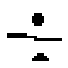

true {'x1': 154, 'x2': 189, 'y1': 113, 'y2': 147}
pred {'x1': 154.24250602722168, 'x2': 185.6477928161621, 'y1': 110.20613670349121, 'y2': 141.15178108215332}
IOU : 0.6919352298672112
---------------
true {'x1': 216, 'x2': 250, 'y1': 116, 'y2': 141}
pred {'x1': 219.45268630981445, 'x2': 241.44060134887695, 'y1': 113.61137390136719, 'y2': 136.2885570526123}
IOU : 0.49428557823280994
---------------
true {'x1': 278, 'x2': 296, 'y1': 113, 'y2': 149}
pred {'x1': 279.862060546875, 'x2': 303.33173751831055, 'y1': 112.84792900085449, 'y2': 144.50839042663574}
IOU : 0.5761294398087732
---------------
true {'x1': 19, 'x2': 55, 'y1': 113, 'y2': 149}
pred {'x1': 15.83384394645691, 'x2': 48.887152671813965, 'y1': 109.02541160583496, 'y2': 147.51357078552246}
IOU : 0.6712740485235541
---------------
{'TP': 10, 'FP': 2, 'TN': 0, 'FN': 3}
Precision:  0.8333333333333334
Recall:  0.7692307692307693


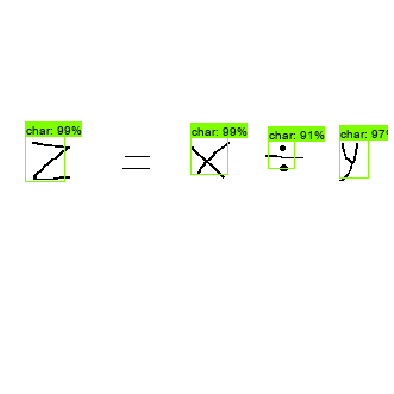

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp0037.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.3261731  xmin:  0.3340298  ymax:  0.43505308  xmax  0.40642986
left:  106.88953399658203  right:  130.05755424499512  top:  104.37539100646973  bottom  139.21698570251465
Top left point: ( 106 ,  104 ) and Bottom right point: ( 130 ,  139 )
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 78.0 %
Symbol_id: 87 , Latex: \} , Confidence Score: 11.29 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 3.9 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.75 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.23 %


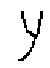

***************
Box: 
ymin:  0.33379075  xmin:  0.5735766  ymax:  0.42998144  xmax  0.65938765
left:  183.5445213317871  right:  211.00404739379883  top:  106.81303977966309  bottom  137.59406089782715
Top left point: ( 183 ,  106 ) and Bottom right point: ( 211 ,  137 )
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 100.0 %


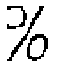

***************
Box: 
ymin:  0.3367242  xmin:  0.7530562  ymax:  0.42073855  xmax  0.86250603
left:  240.9779930114746  right:  276.0019302368164  top:  107.75174140930176  bottom  134.6363353729248
Top left point: ( 240 ,  107 ) and Bottom right point: ( 276 ,  134 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 97.38 %
Symbol_id: 59 , Latex: x , Confidence Score: 2.53 %


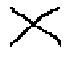

***************
Box: 
ymin:  0.29062077  xmin:  0.029853424  ymax:  0.40828982  xmax  0.122080676
left:  9.553095698356628  right:  39.0658164024353  top:  92.99864768981934  bottom  130.65274238586426
Top left point: ( 9 ,  92 ) and Bottom right point: ( 39 ,  130 )
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 72.22 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 20.15 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.76 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.7 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.85 %


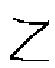

***************
Box: 
ymin:  0.34639367  xmin:  0.22892463  ymax:  0.4018901  xmax  0.30915096
left:  73.2558822631836  right:  98.92830848693848  top:  110.84597587585449  bottom  128.60483169555664
Top left point: ( 73 ,  110 ) and Bottom right point: ( 98 ,  128 )
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 78.83 %
Symbol_id: 104 , Latex: = , Confidence Score: 16.27 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.2 %


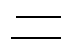

true {'x1': 11, 'x2': 45, 'y1': 99, 'y2': 134}
pred {'x1': 9.553095698356628, 'x2': 39.0658164024353, 'y1': 92.99864768981934, 'y2': 130.65274238586426}
IOU : 0.6287428685806579
---------------
true {'x1': 74, 'x2': 100, 'y1': 100, 'y2': 136}
pred {'x1': 73.2558822631836, 'x2': 98.92830848693848, 'y1': 110.84597587585449, 'y2': 128.60483169555664}
IOU : 0.4663836809126069
---------------
true {'x1': 114, 'x2': 131, 'y1': 105, 'y2': 142}
pred {'x1': 106.88953399658203, 'x2': 130.05755424499512, 'y1': 104.37539100646973, 'y2': 139.21698570251465}
IOU : 0.6195984416535106
---------------
true {'x1': 180, 'x2': 209, 'y1': 105, 'y2': 141}
pred {'x1': 183.5445213317871, 'x2': 211.00404739379883, 'y1': 106.81303977966309, 'y2': 137.59406089782715}
IOU : 0.7086507231221224
---------------
true {'x1': 242, 'x2': 277, 'y1': 106, 'y2': 135}
pred {'x1': 240.9779930114746, 'x2': 276.0019302368164, 'y1': 107.75174140930176, 'y2': 134.6363353729248}
IOU : 0.8768814585554332
---------------
{'TP': 14,

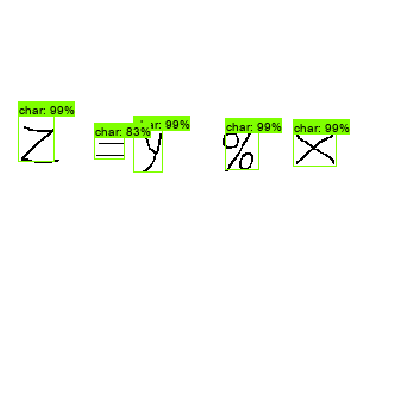

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp0044.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.50612974  xmin:  0.27321777  ymax:  0.5793986  xmax  0.35144293
left:  87.42968559265137  right:  112.46173858642578  top:  161.96151733398438  bottom  185.40754318237305
Top left point: ( 87 ,  161 ) and Bottom right point: ( 112 ,  185 )
CNN/ANN Predictions:
Symbol_id: 37 , Latex: a , Confidence Score: 83.31 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 12.88 %
Symbol_id: 56 , Latex: u , Confidence Score: 2.78 %


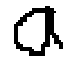

***************
Box: 
ymin:  0.5018033  xmin:  0.07283526  ymax:  0.59806925  xmax  0.15008509
left:  23.3072829246521  right:  48.02722930908203  top:  160.5770492553711  bottom  191.38216018676758
Top left point: ( 23 ,  160 ) and Bottom right point: ( 48 ,  191 )
CNN/ANN Predictions:
Symbol_id: 10 , Latex: K , Confidence Score: 98.49 %
Symbol_id: 17 , Latex: R , Confidence Score: 1.35 %


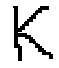

***************
Box: 
ymin:  0.49739337  xmin:  0.5085532  ymax:  0.59008604  xmax  0.595766
left:  162.7370262145996  right:  190.64512252807617  top:  159.16587829589844  bottom  188.82753372192383
Top left point: ( 162 ,  159 ) and Bottom right point: ( 190 ,  188 )
CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 59.45 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 32.6 %
Symbol_id: 55 , Latex: s , Confidence Score: 6.76 %


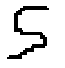

***************
Box: 
ymin:  0.50990945  xmin:  0.16916023  ymax:  0.56792194  xmax  0.25951123
left:  54.13127422332764  right:  83.04359436035156  top:  163.17102432250977  bottom  181.7350196838379
Top left point: ( 54 ,  163 ) and Bottom right point: ( 83 ,  181 )
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 91.56 %
Symbol_id: 104 , Latex: = , Confidence Score: 3.12 %
Symbol_id: 5 , Latex: F , Confidence Score: 1.84 %


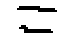

true {'x1': 24, 'x2': 51, 'y1': 142, 'y2': 196}
pred {'x1': 23.3072829246521, 'x2': 48.02722930908203, 'y1': 160.5770492553711, 'y2': 191.38216018676758}
IOU : 0.5003324802428879
---------------
true {'x1': 57, 'x2': 82, 'y1': 149, 'y2': 188}
pred {'x1': 54.13127422332764, 'x2': 83.04359436035156, 'y1': 163.17102432250977, 'y2': 181.7350196838379}
IOU : 0.4430005252714659
---------------
true {'x1': 88, 'x2': 120, 'y1': 160, 'y2': 189}
pred {'x1': 87.42968559265137, 'x2': 112.46173858642578, 'y1': 161.96151733398438, 'y2': 185.40754318237305}
IOU : 0.6092498980566353
---------------
true {'x1': 162, 'x2': 187, 'y1': 157, 'y2': 189}
pred {'x1': 162.7370262145996, 'x2': 190.64512252807617, 'y1': 159.16587829589844, 'y2': 188.82753372192383}
IOU : 0.7924940272957144
---------------
{'TP': 17, 'FP': 4, 'TN': 0, 'FN': 8}
Precision:  0.8095238095238095
Recall:  0.68


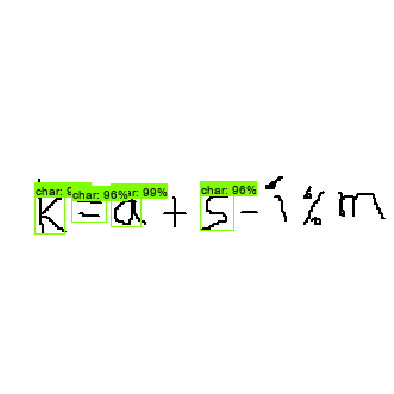

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp0051.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.29632273  xmin:  0.2760508  ymax:  0.3459346  xmax  0.35486767
left:  88.33625793457031  right:  113.55765342712402  top:  94.82327461242676  bottom  110.69907188415527
Top left point: ( 88 ,  94 ) and Bottom right point: ( 113 ,  110 )
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 25.1 %
Symbol_id: 94 , Latex: \div , Confidence Score: 21.16 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 20.74 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 15.15 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 9.78 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.41 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.27 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.12 %


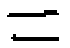

***************
Box: 
ymin:  0.28311527  xmin:  0.06128931  ymax:  0.3745643  xmax  0.14153068
left:  19.612579345703125  right:  45.28981685638428  top:  90.59688568115234  bottom  119.8605728149414
Top left point: ( 19 ,  90 ) and Bottom right point: ( 45 ,  119 )
CNN/ANN Predictions:
Symbol_id: 30 , Latex: 4 , Confidence Score: 99.6 %


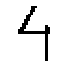

***************
Box: 
ymin:  0.23286669  xmin:  0.46969494  ymax:  0.36815545  xmax  0.57434076
left:  150.30238151550293  right:  183.78904342651367  top:  74.51734066009521  bottom  117.80974388122559
Top left point: ( 150 ,  74 ) and Bottom right point: ( 183 ,  117 )
CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 99.54 %


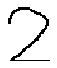

true {'x1': 25, 'x2': 48, 'y1': 84, 'y2': 126}
pred {'x1': 19.612579345703125, 'x2': 45.28981685638428, 'y1': 90.59688568115234, 'y2': 119.8605728149414}
IOU : 0.5284134665240857
---------------
true {'x1': 87, 'x2': 114, 'y1': 83, 'y2': 123}
pred {'x1': 88.33625793457031, 'x2': 113.55765342712402, 'y1': 94.82327461242676, 'y2': 110.69907188415527}
IOU : 0.37074977939802783
---------------
true {'x1': 148, 'x2': 188, 'y1': 75, 'y2': 122}
pred {'x1': 150.30238151550293, 'x2': 183.78904342651367, 'y1': 74.51734066009521, 'y2': 117.80974388122559}
IOU : 0.7560297739999093
---------------
{'TP': 19, 'FP': 5, 'TN': 0, 'FN': 9}
Precision:  0.7916666666666666
Recall:  0.6785714285714286


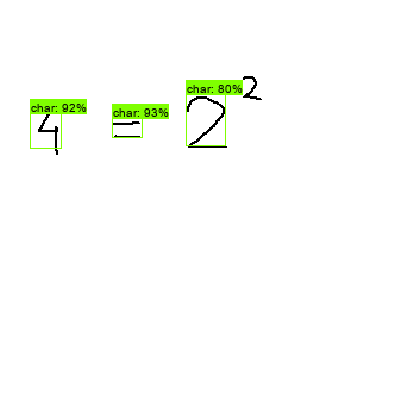

-------------------------
Detecting Boxes for Image:  research/object_detection/training/test/exp9.png
Image shape:  (320, 320, 3)
***************
Box: 
ymin:  0.42423746  xmin:  0.4453438  ymax:  0.5399972  xmax  0.5036146
left:  142.51001358032227  right:  161.15667343139648  top:  135.7559871673584  bottom  172.79911041259766
Top left point: ( 142 ,  135 ) and Bottom right point: ( 161 ,  172 )
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 86.24 %
Symbol_id: 24 , Latex: Y , Confidence Score: 5.06 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.22 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.57 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.28 %


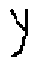

***************
Box: 
ymin:  0.44657612  xmin:  0.23004031  ymax:  0.5237957  xmax  0.2984368
left:  73.61289978027344  right:  95.4997730255127  top:  142.90435791015625  bottom  167.61463165283203
Top left point: ( 73 ,  142 ) and Bottom right point: ( 95 ,  167 )
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 99.9 %


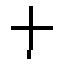

***************
Box: 
ymin:  0.45239797  xmin:  0.6390137  ymax:  0.5036976  xmax  0.7168195
left:  204.4843864440918  right:  229.3822479248047  top:  144.7673511505127  bottom  161.18322372436523
Top left point: ( 204 ,  144 ) and Bottom right point: ( 229 ,  161 )
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 53.75 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 20.82 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 12.67 %
Symbol_id: 83 , Latex: - , Confidence Score: 3.4 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 2.8 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.64 %


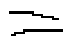

***************
Box: 
ymin:  0.43931293  xmin:  0.023239652  ymax:  0.54628336  xmax  0.10514065
left:  7.436688542366028  right:  33.645007610321045  top:  140.58013916015625  bottom  174.81067657470703
Top left point: ( 7 ,  140 ) and Bottom right point: ( 33 ,  174 )
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 94.23 %
Symbol_id: 59 , Latex: x , Confidence Score: 5.62 %


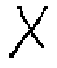

***************
Box: 
ymin:  0.44205776  xmin:  0.858077  ymax:  0.52738947  xmax  0.9661817
left:  274.5846366882324  right:  309.1781425476074  top:  141.45848274230957  bottom  168.76462936401367
Top left point: ( 274 ,  141 ) and Bottom right point: ( 309 ,  168 )
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 78.95 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.8 %
Symbol_id: 90 , Latex: \% , Confidence Score: 4.32 %
Symbol_id: 11 , Latex: L , Confidence Score: 1.99 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.55 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.49 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.35 %
Symbol_id: 78 , Latex: < , Confidence Score: 1.22 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.05 %


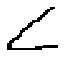

true {'x1': 8, 'x2': 32, 'y1': 139, 'y2': 175}
pred {'x1': 7.436688542366028, 'x2': 33.645007610321045, 'y1': 140.58013916015625, 'y2': 174.81067657470703}
IOU : 0.8743507213734574
---------------
true {'x1': 74, 'x2': 97, 'y1': 140, 'y2': 170}
pred {'x1': 73.61289978027344, 'x2': 95.4997730255127, 'y1': 142.90435791015625, 'y2': 167.61463165283203}
IOU : 0.7594219397040993
---------------
true {'x1': 143, 'x2': 160, 'y1': 137, 'y2': 174}
pred {'x1': 142.51001358032227, 'x2': 161.15667343139648, 'y1': 135.7559871673584, 'y2': 172.79911041259766}
IOU : 0.8557809274282706
---------------
true {'x1': 204, 'x2': 230, 'y1': 144, 'y2': 161}
pred {'x1': 204.4843864440918, 'x2': 229.3822479248047, 'y1': 144.7673511505127, 'y2': 161.18322372436523}
IOU : 0.9050442091178654
---------------
true {'x1': 272, 'x2': 309, 'y1': 133, 'y2': 169}
pred {'x1': 274.5846366882324, 'x2': 309.1781425476074, 'y1': 141.45848274230957, 'y2': 168.76462936401367}
IOU : 0.7029515978605931
---------------
{'TP': 24,

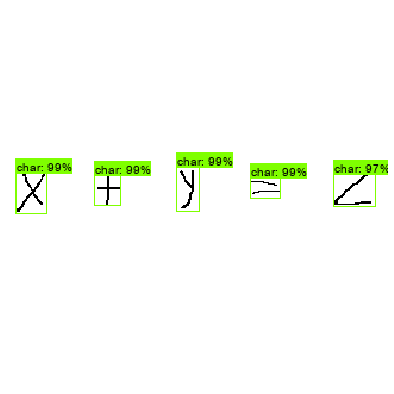

Mean Average Precision (mAP):  0.16614420062695923


In [15]:
cnf = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
map_data = []
iou_data = []

for image_path in TEST_IMAGE_PATHS:
    image_path = image_path.replace("\\", "/")
    im_name = image_path.split("/")[-1]
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    if len(image_np.shape) < 3:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    else:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    print('-'*25)
    print('Detecting Boxes for Image: ', image_path)
    print('Image shape: ', image_np.shape)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    # Visualization of the results of a detection.
    """
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    """
    # cv2.imshow('scene', image_np)
    # plt.show()

    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    boxes_pred = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.array([output_dict['detection_boxes'][i]]),
                np.array([output_dict['detection_classes'][i]]),
                np.array([output_dict['detection_scores'][i]]),
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=1)
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width,
                                          xmax * im_width,
                                          ymin * im_height,
                                          ymax * im_height)
            print('*'*15)
            print("Box: ")
            print("ymin: ", ymin," xmin: ", xmin, " ymax: ", ymax," xmax ", xmax)
            print("left: ", left," right: ", right," top: ", top," bottom ", bottom)
            print("Top left point: (",int(left),", ",int(top),") and Bottom right point: (",int(right),", ",int(bottom),")")
            
            cropped_image = image.crop((left, top, right, bottom))
            
            
            # boxes_pred.append([left, right, top, bottom])
            boxes_pred.append({
                'x1':left,
                'x2':right,
                'y1':top,
                'y2':bottom
            })
            
            # Predict label for cropped image with CNN
            c_im = np.asarray(cropped_image)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_BGRA2RGBA)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2RGB)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2GRAY)
            c_im = cv2.resize(c_im, (32,32))
            c_im = c_im / 255.0
            # Symbol Prediction
            # CNN
            c_im = np.resize(c_im, (1, 1, 32, 32))
            res = cnn.predict(c_im)
            # ANN
            #c_im = c_im.flatten().reshape((1, 32*32))
            #print(c_im.shape)
            #res = ann.predict(c_im)
            #
            res = res.flatten()
            # lbl = one_hot_encode_to_char(res, threshold=0.1)
            # if type(lbl) == list: lbl = lbl[0]
            # print("Symbol is :", symbols.loc[symbols['new_id']==lbl])
            lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
            print("CNN/ANN Predictions:")
            for j in lbls:
                symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
                latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
                print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')
            plt.figure(figsize=(1,1))
            plt.axis('off')
            temp_ = np.asarray(cropped_image)
            plt.imshow(temp_)
            plt.show()
            cropped_images.append(np.asarray(cropped_image))
            #cv2.imshow('model', np.asarray(cropped_image))
    # calculate IOU
    xml_path = image_path[:-3]+'xml'
    xml_path = xml_path.replace("\\", "/")
    boxes_true = read_annotation(xml_path)

    ious = []
    iou_threshold = 0.5
    # dont reset cnf
    # cnf = {'TP':0, 'FP':0, 'TN':0, 'FN':0}
    for t in boxes_true:
        box_present = False
        for p in boxes_pred:
            if p['x1'] <= t['x1'] + 10 and p['x1'] >= t['x1'] - 10:
                print('true', t)
                print('pred', p)
                iou = get_iou(t, p)
                iou_data.append(iou)
                ious.append(iou)
                print('IOU :', iou)
                print('-----'*3)
                box_present = True
                if iou > iou_threshold:
                    cnf['TP'] += 1
                else:
                    cnf['FP'] += 1
                break
        if not box_present:
            cnf['FN'] += 1
    print(cnf)
    
    # prevent division by 0 error
    if cnf['TP'] + cnf['FP'] != 0 and cnf['TP'] + cnf['FN'] != 0:
        precision = cnf['TP'] / (cnf['TP'] + cnf['FP'])
        print('Precision: ', precision)
        recall = cnf['TP']/ (cnf['TP'] + cnf['FN'])
        print('Recall: ', recall)
        map_data.append((precision, recall))
    #

    plt.figure(figsize=(7,7))
    plt.axis('off')
    temp_ = cv2.resize(image_np, (int(im_width), int(im_height)))
    plt.imshow(temp_)
    plt.show()
    #cv2.imshow(im_name, cv2.resize(image_np, (int(im_width), int(im_height))))
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

# Calculate mAP (Mean Average Precision Score)
mean_ap = calculate_map(map_data)
print("Mean Average Precision (mAP): ", mean_ap)

print("Mean IOU: ", np.mean(iou_data))

Character Segmentation Model

In [13]:
def remove_wspaces(img_):
    gray_ = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    gray_ = 255*(gray_ < 128).astype(np.uint8) # To invert the text to white
    coords_ = cv2.findNonZero(gray_) # Find all non-zero points (text)
    x_, y_, w_, h_ = cv2.boundingRect(coords_) # Find minimum spanning bounding box
    rect_ = img_[y_:y_+h_, x_:x_+w_] # Crop the image - note we do this on the original image
    
    # add a white border of 1 pixel
    bordersize=2
    rect_ = cv2.copyMakeBorder(
        rect_,
        top=bordersize,
        bottom=bordersize,
        left=bordersize,
        right=bordersize,
        borderType=cv2.BORDER_CONSTANT,
        value=[255, 255, 255]
    )
    return rect_

Image path:  research/object_detection/training/test_images\exp0010.png


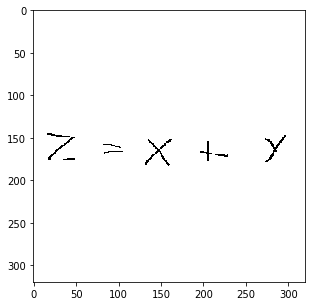

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


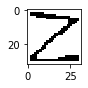

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 61.67 %
Symbol_id: 104 , Latex: = , Confidence Score: 27.63 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.54 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.29 %


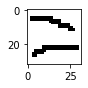

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.32 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 5.33 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.1 %


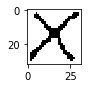

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 41.24 %
Symbol_id: 44 , Latex: h , Confidence Score: 30.65 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 17.12 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.87 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.47 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.39 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.18 %
Symbol_id: 32 , Latex: 6 , Confidence Score: 1.06 %


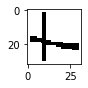

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.03 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.79 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.59 %


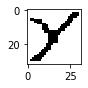

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0011.png


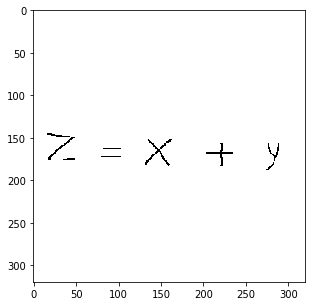

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


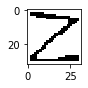

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


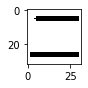

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 91.32 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 5.33 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.1 %


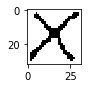

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 99.64 %


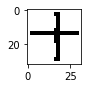

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


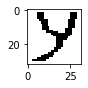

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0012.png


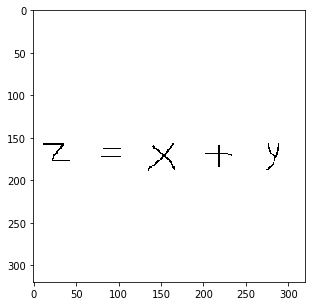

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


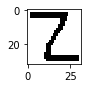

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


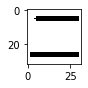

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.21 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.43 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.13 %


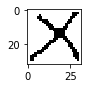

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 97.26 %


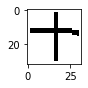

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


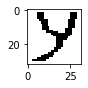

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0013.png


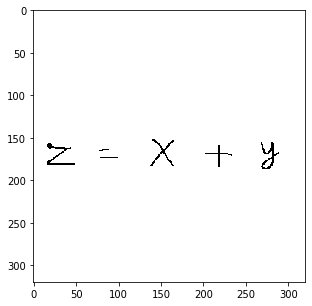

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 55.38 %
Symbol_id: 90 , Latex: \% , Confidence Score: 30.32 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 7.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.97 %


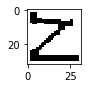

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 78.96 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 9.81 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.21 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 3.98 %


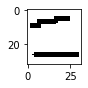

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.22 %


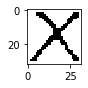

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 97.26 %


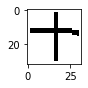

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.77 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.67 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %


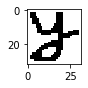

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0014.png


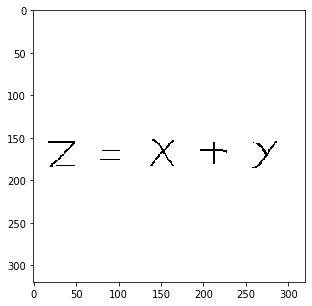

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 59.39 %
Symbol_id: 61 , Latex: z , Confidence Score: 19.23 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.97 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 7.88 %


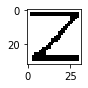

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


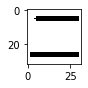

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.22 %


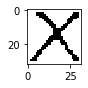

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 97.26 %


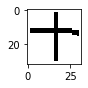

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 31.43 %
Symbol_id: 92 , Latex: \times , Confidence Score: 26.13 %
Symbol_id: 60 , Latex: y , Confidence Score: 13.53 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.64 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 10.97 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.61 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.97 %


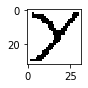

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0015.png


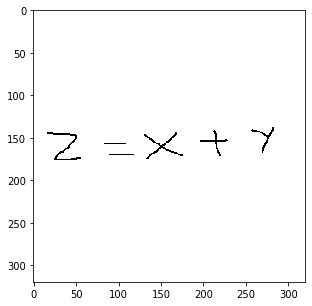

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.95 %
Symbol_id: 25 , Latex: Z , Confidence Score: 17.43 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.79 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.77 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.16 %


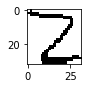

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 42.69 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 36.79 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 6.4 %
Symbol_id: 39 , Latex: c , Confidence Score: 2.67 %
Symbol_id: 51 , Latex: o , Confidence Score: 2.02 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.72 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.29 %


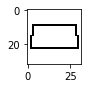

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 87.39 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 4.01 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.56 %
Symbol_id: 51 , Latex: o , Confidence Score: 1.89 %


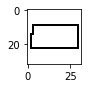

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.75 %


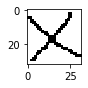

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 98.96 %


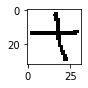

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 72.75 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 20.9 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.37 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.66 %
Symbol_id: 60 , Latex: y , Confidence Score: 1.49 %


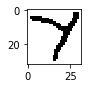

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0016.png


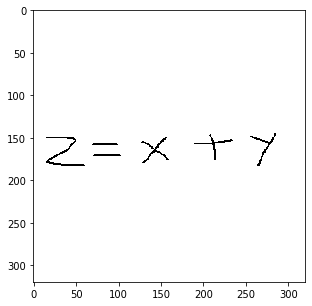

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 87.45 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.65 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 2.95 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.59 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.2 %


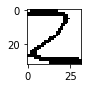

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 47.11 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 32.07 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 7.1 %
Symbol_id: 51 , Latex: o , Confidence Score: 2.31 %
Symbol_id: 39 , Latex: c , Confidence Score: 2.3 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.68 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.03 %


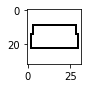

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 76.83 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 10.36 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 4.1 %
Symbol_id: 51 , Latex: o , Confidence Score: 1.82 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.03 %


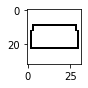

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 95.87 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 3.54 %


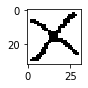

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 17.11 %
Symbol_id: 49 , Latex: m , Confidence Score: 12.46 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 12.1 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 11.56 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 9.21 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.93 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 4.58 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 4.57 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.38 %
Symbol_id: 84 , Latex: + , Confidence Score: 2.57 %
Symbol_id: 42 , Latex: f , Confidence Score: 2.07 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.99 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.62 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.4 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.05 %


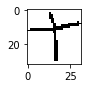

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 96.5 %
Symbol_id: 60 , Latex: y , Confidence Score: 2.9 %


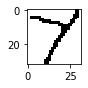

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0017.png


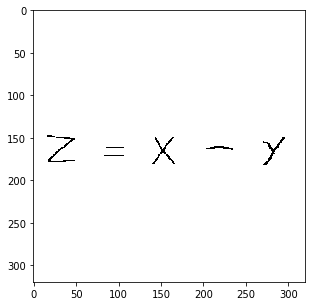

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


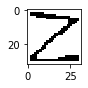

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


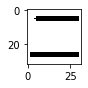

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 74.09 %
Symbol_id: 59 , Latex: x , Confidence Score: 18.55 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.05 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.79 %


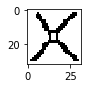

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 37.49 %
Symbol_id: 7 , Latex: H , Confidence Score: 32.86 %
Symbol_id: 12 , Latex: M , Confidence Score: 7.26 %
Symbol_id: 56 , Latex: u , Confidence Score: 4.59 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.32 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.31 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.14 %
Symbol_id: 37 , Latex: a , Confidence Score: 1.13 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.06 %


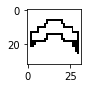

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.03 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.79 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.59 %


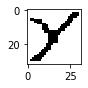

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0018.png


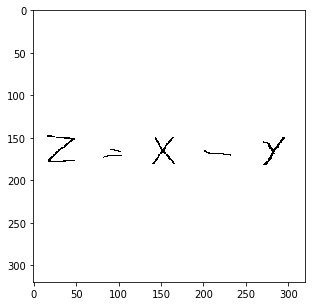

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


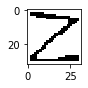

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 61.67 %
Symbol_id: 104 , Latex: = , Confidence Score: 27.63 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.54 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.29 %


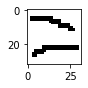

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 74.09 %
Symbol_id: 59 , Latex: x , Confidence Score: 18.55 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.05 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.79 %


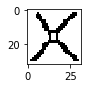

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 14.56 %
Symbol_id: 7 , Latex: H , Confidence Score: 11.42 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 10.8 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 10.29 %
Symbol_id: 44 , Latex: h , Confidence Score: 8.25 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 7.86 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 4.44 %
Symbol_id: 56 , Latex: u , Confidence Score: 3.91 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 3.33 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.18 %
Symbol_id: 12 , Latex: M , Confidence Score: 2.14 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.88 %
Symbol_id: 20 , Latex: U , Confidence Score: 1.73 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.6 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.42 %
Symbol_id: 58 , Latex: w , Confidence Score: 1.27 %
Symbol_id: 18 , Latex: S , Confidence Score: 1.1 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.09 %
Symbol_id:

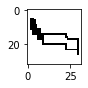

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.03 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.79 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.59 %


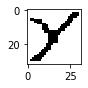

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0019.png


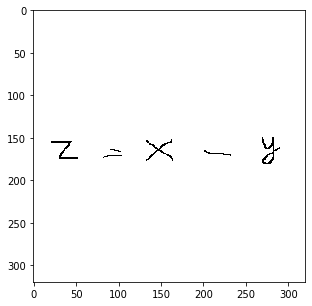

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


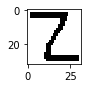

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 61.67 %
Symbol_id: 104 , Latex: = , Confidence Score: 27.63 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.54 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.29 %


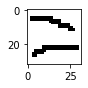

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


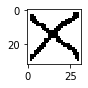

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 14.56 %
Symbol_id: 7 , Latex: H , Confidence Score: 11.42 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 10.8 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 10.29 %
Symbol_id: 44 , Latex: h , Confidence Score: 8.25 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 7.86 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 4.44 %
Symbol_id: 56 , Latex: u , Confidence Score: 3.91 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 3.33 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.18 %
Symbol_id: 12 , Latex: M , Confidence Score: 2.14 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.88 %
Symbol_id: 20 , Latex: U , Confidence Score: 1.73 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.6 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.42 %
Symbol_id: 58 , Latex: w , Confidence Score: 1.27 %
Symbol_id: 18 , Latex: S , Confidence Score: 1.1 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.09 %
Symbol_id:

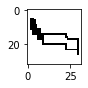

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.77 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.67 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %


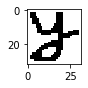

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0020.png


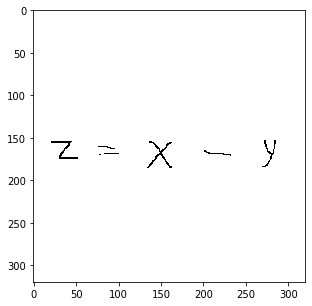

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


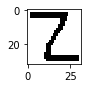

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 61.67 %
Symbol_id: 104 , Latex: = , Confidence Score: 27.63 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.54 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.29 %


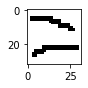

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.22 %


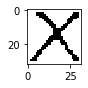

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 14.56 %
Symbol_id: 7 , Latex: H , Confidence Score: 11.42 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 10.8 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 10.29 %
Symbol_id: 44 , Latex: h , Confidence Score: 8.25 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 7.86 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 4.44 %
Symbol_id: 56 , Latex: u , Confidence Score: 3.91 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 3.33 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.18 %
Symbol_id: 12 , Latex: M , Confidence Score: 2.14 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.88 %
Symbol_id: 20 , Latex: U , Confidence Score: 1.73 %
Symbol_id: 101 , Latex: \| , Confidence Score: 1.6 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.42 %
Symbol_id: 58 , Latex: w , Confidence Score: 1.27 %
Symbol_id: 18 , Latex: S , Confidence Score: 1.1 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.09 %
Symbol_id:

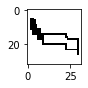

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


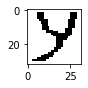

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0021.png


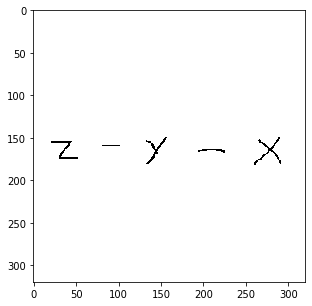

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


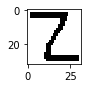

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


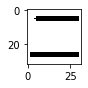

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.03 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.79 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.59 %


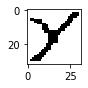

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 37.49 %
Symbol_id: 7 , Latex: H , Confidence Score: 32.86 %
Symbol_id: 12 , Latex: M , Confidence Score: 7.26 %
Symbol_id: 56 , Latex: u , Confidence Score: 4.59 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 2.32 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.31 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.14 %
Symbol_id: 37 , Latex: a , Confidence Score: 1.13 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.06 %


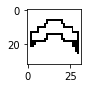

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.21 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.43 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.13 %


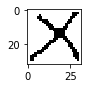

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0022.png


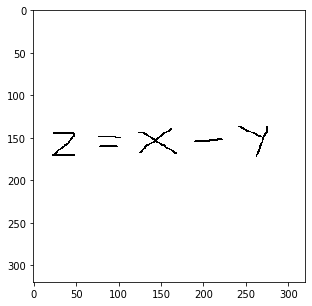

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 59.23 %
Symbol_id: 25 , Latex: Z , Confidence Score: 20.05 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 10.46 %
Symbol_id: 61 , Latex: z , Confidence Score: 8.67 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.04 %


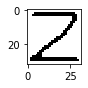

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 93.09 %
Symbol_id: 104 , Latex: = , Confidence Score: 2.64 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.0 %


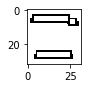

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.66 %


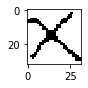

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 16.57 %
Symbol_id: 79 , Latex: > , Confidence Score: 14.07 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 10.96 %
Symbol_id: 88 , Latex: \& , Confidence Score: 7.82 %
Symbol_id: 58 , Latex: w , Confidence Score: 6.54 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 4.99 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 3.93 %
Symbol_id: 22 , Latex: W , Confidence Score: 3.73 %
Symbol_id: 104 , Latex: = , Confidence Score: 2.85 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 2.75 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.78 %
Symbol_id: 57 , Latex: v , Confidence Score: 1.77 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.62 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.61 %
Symbol_id: 37 , Latex: a , Confidence Score: 1.27 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 1.17 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.14 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 

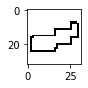

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 93.13 %
Symbol_id: 60 , Latex: y , Confidence Score: 4.9 %


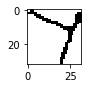

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0023.png


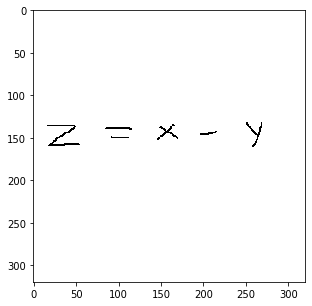

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 87.03 %
Symbol_id: 90 , Latex: \% , Confidence Score: 7.25 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.64 %


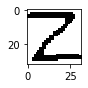

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 96.01 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.1 %


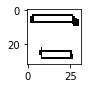

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 77.28 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 21.97 %


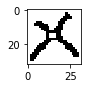

CNN/ANN Predictions:
Symbol_id: 70 , Latex: \mu , Confidence Score: 80.3 %
Symbol_id: 58 , Latex: w , Confidence Score: 4.39 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 3.43 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 2.85 %
Symbol_id: 22 , Latex: W , Confidence Score: 2.53 %
Symbol_id: 79 , Latex: > , Confidence Score: 2.28 %


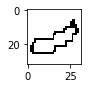

CNN/ANN Predictions:
Symbol_id: 24 , Latex: Y , Confidence Score: 35.95 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 32.08 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 16.54 %
Symbol_id: 60 , Latex: y , Confidence Score: 5.22 %
Symbol_id: 21 , Latex: V , Confidence Score: 3.39 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.14 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.35 %


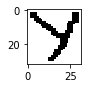

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0024.png


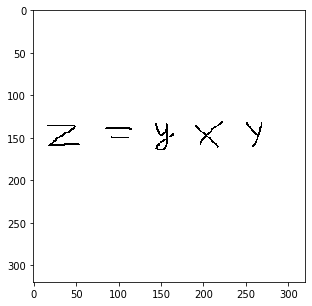

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 87.03 %
Symbol_id: 90 , Latex: \% , Confidence Score: 7.25 %
Symbol_id: 61 , Latex: z , Confidence Score: 5.64 %


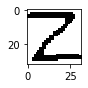

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 96.01 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.1 %


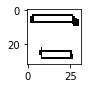

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.77 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.67 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %


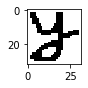

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 71.81 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 24.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.26 %


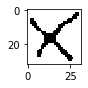

CNN/ANN Predictions:
Symbol_id: 24 , Latex: Y , Confidence Score: 35.95 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 32.08 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 16.54 %
Symbol_id: 60 , Latex: y , Confidence Score: 5.22 %
Symbol_id: 21 , Latex: V , Confidence Score: 3.39 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.14 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.35 %


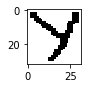

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0025.png


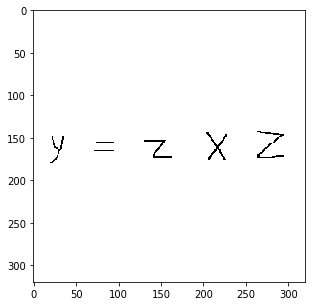

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


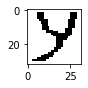

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


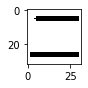

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


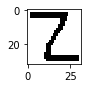

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.77 %


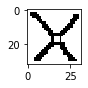

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


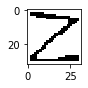

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0026.png


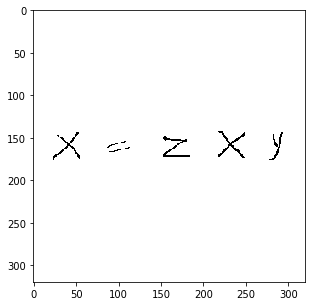

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.21 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.43 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.13 %


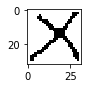

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 51.14 %
Symbol_id: 89 , Latex: \# , Confidence Score: 14.83 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 10.66 %
Symbol_id: 104 , Latex: = , Confidence Score: 8.7 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 7.08 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.73 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 1.58 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.51 %


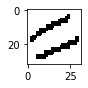

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 55.38 %
Symbol_id: 90 , Latex: \% , Confidence Score: 30.32 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 7.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 2.98 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.97 %


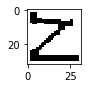

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.67 %


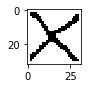

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 34.29 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 28.34 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 17.8 %
Symbol_id: 13 , Latex: N , Confidence Score: 5.64 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.77 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.89 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.38 %


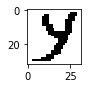

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0027.png


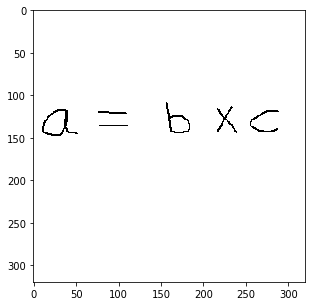

CNN/ANN Predictions:
Symbol_id: 16 , Latex: Q , Confidence Score: 82.13 %
Symbol_id: 37 , Latex: a , Confidence Score: 8.21 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.65 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.54 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.41 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.18 %
Symbol_id: 6 , Latex: G , Confidence Score: 1.0 %


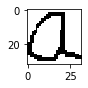

CNN/ANN Predictions:
Symbol_id: 74 , Latex: \omega , Confidence Score: 88.51 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 3.04 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 2.47 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.12 %


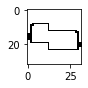

CNN/ANN Predictions:
Symbol_id: 95 , Latex: \cap , Confidence Score: 32.45 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 16.74 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 16.71 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 10.31 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 7.28 %
Symbol_id: 51 , Latex: o , Confidence Score: 3.94 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 1.59 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.54 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.21 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.2 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.17 %


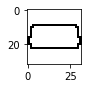

CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 66.03 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 19.08 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 4.97 %
Symbol_id: 40 , Latex: d , Confidence Score: 3.08 %
Symbol_id: 18 , Latex: S , Confidence Score: 1.4 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.21 %
Symbol_id: 44 , Latex: h , Confidence Score: 1.01 %


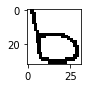

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 97.41 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.3 %


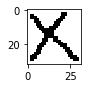

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 96.52 %
Symbol_id: 39 , Latex: c , Confidence Score: 2.44 %


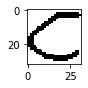

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0028.png


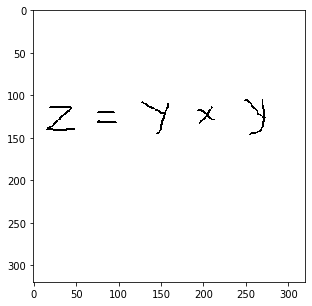

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 83.57 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.51 %
Symbol_id: 61 , Latex: z , Confidence Score: 7.37 %


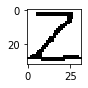

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 38.84 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 30.62 %
Symbol_id: 104 , Latex: = , Confidence Score: 14.18 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 8.59 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.48 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.68 %


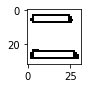

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 51.78 %
Symbol_id: 60 , Latex: y , Confidence Score: 43.49 %
Symbol_id: 66 , Latex: \eta , Confidence Score: 1.35 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.2 %


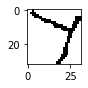

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 50.62 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 30.7 %
Symbol_id: 89 , Latex: \# , Confidence Score: 12.8 %
Symbol_id: 92 , Latex: \times , Confidence Score: 2.58 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.17 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.08 %


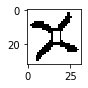

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 93.09 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 4.06 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.05 %


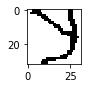

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0029.png


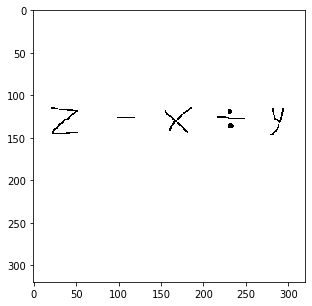

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


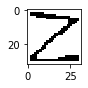

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


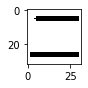

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 71.81 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 24.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.26 %


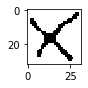

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 88.82 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 10.27 %


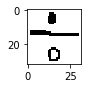

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


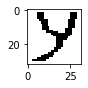

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0030.png


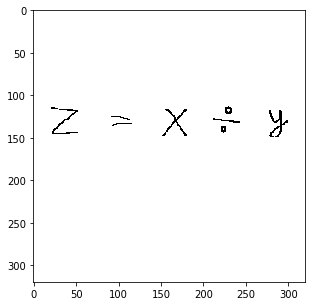

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


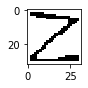

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 61.67 %
Symbol_id: 104 , Latex: = , Confidence Score: 27.63 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.54 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.29 %


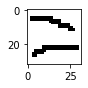

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.22 %


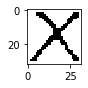

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 95.42 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 3.4 %


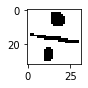

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.77 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.67 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %


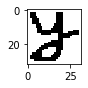

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0031.png


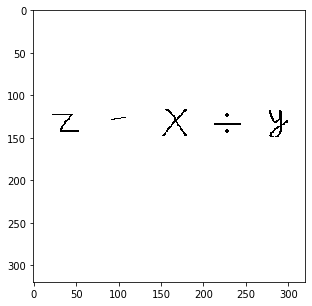

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


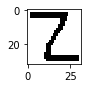

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 78.96 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 9.81 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.21 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 3.98 %


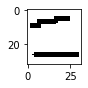

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.59 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.22 %


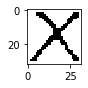

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.72 %


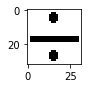

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 95.77 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.67 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.48 %


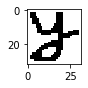

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0032.png


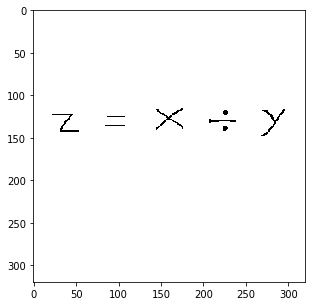

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 61.92 %
Symbol_id: 25 , Latex: Z , Confidence Score: 22.84 %
Symbol_id: 61 , Latex: z , Confidence Score: 10.47 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.01 %


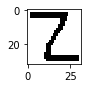

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


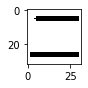

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


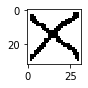

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 95.6 %
Symbol_id: 84 , Latex: + , Confidence Score: 1.78 %


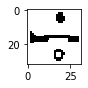

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 31.43 %
Symbol_id: 92 , Latex: \times , Confidence Score: 26.13 %
Symbol_id: 60 , Latex: y , Confidence Score: 13.53 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.64 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 10.97 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.61 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.97 %


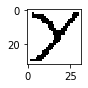

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0033.png


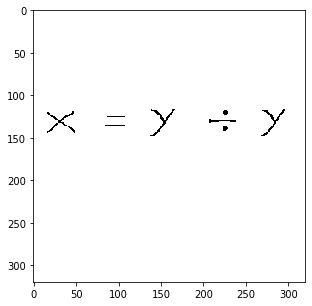

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


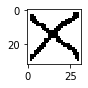

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


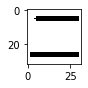

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 31.43 %
Symbol_id: 92 , Latex: \times , Confidence Score: 26.13 %
Symbol_id: 60 , Latex: y , Confidence Score: 13.53 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.64 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 10.97 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.61 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.97 %


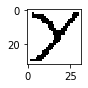

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 95.6 %
Symbol_id: 84 , Latex: + , Confidence Score: 1.78 %


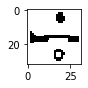

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 31.43 %
Symbol_id: 92 , Latex: \times , Confidence Score: 26.13 %
Symbol_id: 60 , Latex: y , Confidence Score: 13.53 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.64 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 10.97 %
Symbol_id: 24 , Latex: Y , Confidence Score: 2.61 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.97 %


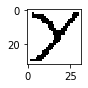

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0034.png


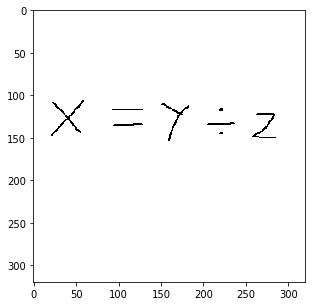

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.56 %


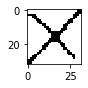

CNN/ANN Predictions:
Symbol_id: 95 , Latex: \cap , Confidence Score: 32.45 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 16.74 %
Symbol_id: 74 , Latex: \omega , Confidence Score: 16.71 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 10.31 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 7.28 %
Symbol_id: 51 , Latex: o , Confidence Score: 3.94 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 1.59 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.54 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.21 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.2 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.17 %


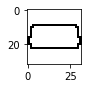

CNN/ANN Predictions:
Symbol_id: 74 , Latex: \omega , Confidence Score: 33.68 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 23.8 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 18.16 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 5.87 %
Symbol_id: 94 , Latex: \div , Confidence Score: 5.07 %
Symbol_id: 79 , Latex: > , Confidence Score: 4.57 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 3.26 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.15 %


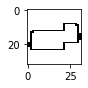

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 67.93 %
Symbol_id: 60 , Latex: y , Confidence Score: 31.29 %


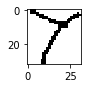

CNN/ANN Predictions:
Symbol_id: 71 , Latex: \Pi , Confidence Score: 44.88 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 37.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.33 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 2.9 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.3 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.09 %


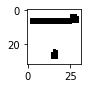

CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 65.43 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 19.5 %
Symbol_id: 105 , Latex: //( , Confidence Score: 5.12 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 3.08 %
Symbol_id: 106 , Latex: //) , Confidence Score: 1.85 %


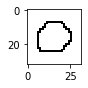

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 63.32 %
Symbol_id: 61 , Latex: z , Confidence Score: 17.45 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 8.27 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.98 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.32 %


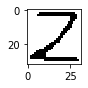

number of char in image: 7
Image path:  research/object_detection/training/test_images\exp0035.png


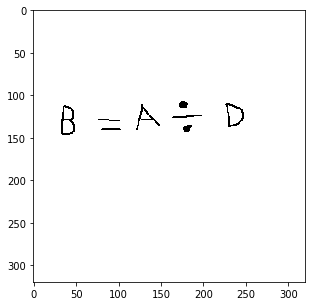

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 99.52 %


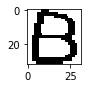

CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 38.5 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 36.68 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 15.25 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 3.22 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.5 %


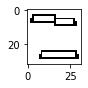

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 97.98 %


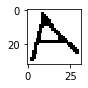

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.61 %


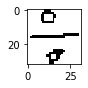

CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 78.83 %
Symbol_id: 89 , Latex: \# , Confidence Score: 8.71 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.39 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.37 %
Symbol_id: 50 , Latex: n , Confidence Score: 1.36 %


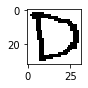

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0036.png


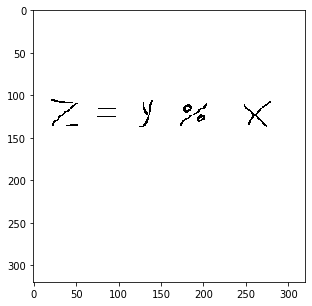

CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 75.97 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 11.73 %


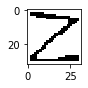

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


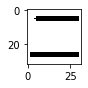

CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 34.29 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 28.34 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 17.8 %
Symbol_id: 13 , Latex: N , Confidence Score: 5.64 %
Symbol_id: 24 , Latex: Y , Confidence Score: 4.77 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.89 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.38 %


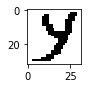

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.99 %


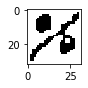

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 71.81 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 24.7 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.26 %


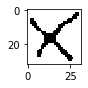

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0037.png


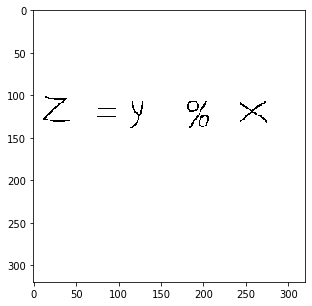

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 77.77 %
Symbol_id: 61 , Latex: z , Confidence Score: 14.17 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.9 %


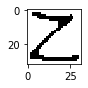

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


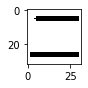

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


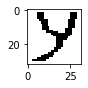

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 56.39 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 40.27 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.77 %


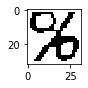

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


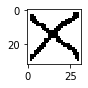

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0038.png


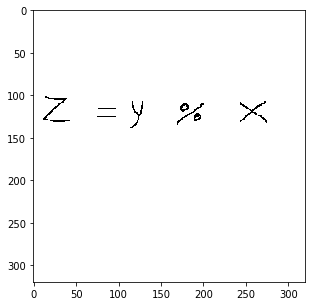

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 77.77 %
Symbol_id: 61 , Latex: z , Confidence Score: 14.17 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.9 %


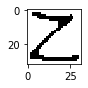

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 48.05 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 25.25 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 12.67 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.92 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.62 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.99 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


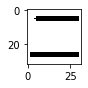

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


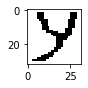

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.99 %


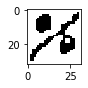

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


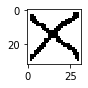

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0039.png


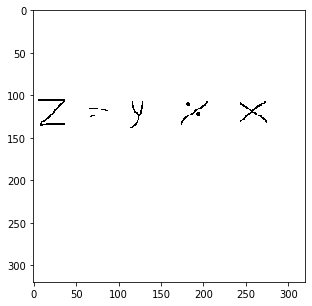

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 59.39 %
Symbol_id: 61 , Latex: z , Confidence Score: 19.23 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.97 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 7.88 %


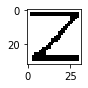

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 61.67 %
Symbol_id: 104 , Latex: = , Confidence Score: 27.63 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.54 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.49 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.29 %


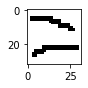

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


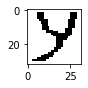

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 38.25 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 14.68 %
Symbol_id: 90 , Latex: \% , Confidence Score: 12.09 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 11.33 %
Symbol_id: 7 , Latex: H , Confidence Score: 7.76 %
Symbol_id: 59 , Latex: x , Confidence Score: 7.32 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 2.0 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.26 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.21 %


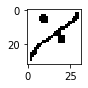

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


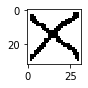

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0040.png


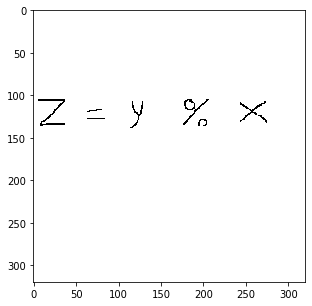

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 59.39 %
Symbol_id: 61 , Latex: z , Confidence Score: 19.23 %
Symbol_id: 90 , Latex: \% , Confidence Score: 11.97 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 7.88 %


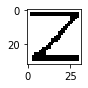

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 78.96 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 9.81 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 4.21 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 3.98 %


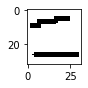

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 62.25 %
Symbol_id: 60 , Latex: y , Confidence Score: 23.8 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 5.29 %
Symbol_id: 24 , Latex: Y , Confidence Score: 3.19 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.2 %


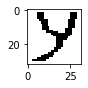

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 97.67 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.56 %


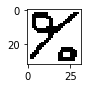

CNN/ANN Predictions:
Symbol_id: 89 , Latex: \# , Confidence Score: 86.3 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 3.67 %
Symbol_id: 13 , Latex: N , Confidence Score: 3.14 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.95 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.78 %


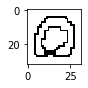

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.76 %


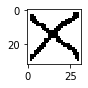

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0041.png


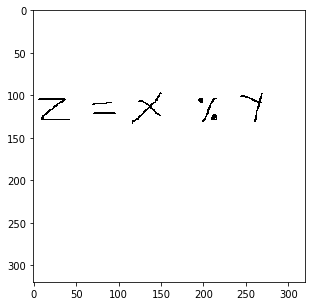

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 95.73 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.64 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.49 %


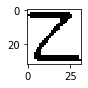

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 43.47 %
Symbol_id: 104 , Latex: = , Confidence Score: 19.69 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 8.52 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 7.38 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 6.42 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.21 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.71 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 2.27 %


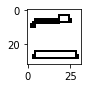

CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.11 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 3.65 %


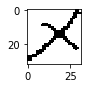

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 54.25 %
Symbol_id: 92 , Latex: \times , Confidence Score: 18.73 %
Symbol_id: 59 , Latex: x , Confidence Score: 13.35 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 4.71 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.34 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 2.58 %


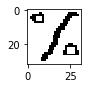

CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 89.97 %
Symbol_id: 60 , Latex: y , Confidence Score: 5.89 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 2.48 %


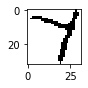

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0042.png


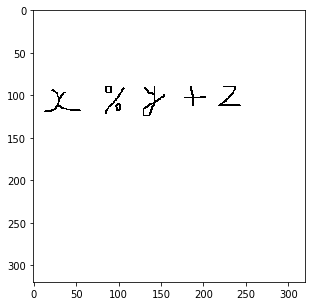

CNN/ANN Predictions:
Symbol_id: 10 , Latex: K , Confidence Score: 59.86 %
Symbol_id: 47 , Latex: k , Confidence Score: 26.69 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 2.55 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.47 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.31 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 1.26 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.01 %


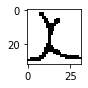

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.91 %


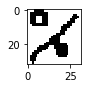

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 50.13 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 45.45 %


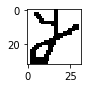

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 54.6 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 38.4 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 3.85 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.24 %


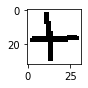

CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 54.74 %
Symbol_id: 90 , Latex: \% , Confidence Score: 17.23 %
Symbol_id: 61 , Latex: z , Confidence Score: 13.97 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 13.66 %


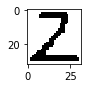

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0043.png


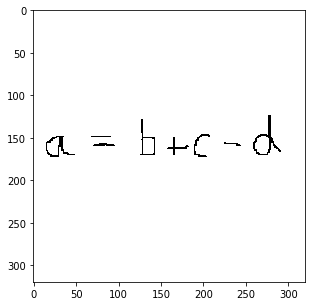

CNN/ANN Predictions:
Symbol_id: 37 , Latex: a , Confidence Score: 58.14 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 21.26 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 17.31 %


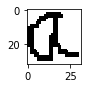

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 51.94 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 24.96 %
Symbol_id: 104 , Latex: = , Confidence Score: 11.22 %
Symbol_id: 90 , Latex: \% , Confidence Score: 5.68 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.32 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.16 %


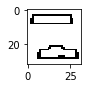

CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 88.82 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 10.42 %


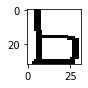

CNN/ANN Predictions:
Symbol_id: 58 , Latex: w , Confidence Score: 34.86 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 26.09 %
Symbol_id: 10 , Latex: K , Confidence Score: 15.07 %
Symbol_id: 7 , Latex: H , Confidence Score: 7.46 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 2.02 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.99 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.85 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.81 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.64 %
Symbol_id: 102 , Latex: \infty , Confidence Score: 1.33 %
Symbol_id: 40 , Latex: d , Confidence Score: 1.02 %


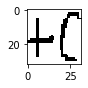

CNN/ANN Predictions:
Symbol_id: 103 , Latex: \ohm , Confidence Score: 13.83 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 9.77 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 8.92 %
Symbol_id: 101 , Latex: \| , Confidence Score: 7.41 %
Symbol_id: 49 , Latex: m , Confidence Score: 5.92 %
Symbol_id: 56 , Latex: u , Confidence Score: 5.67 %
Symbol_id: 66 , Latex: \eta , Confidence Score: 5.46 %
Symbol_id: 104 , Latex: = , Confidence Score: 5.03 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 4.19 %
Symbol_id: 7 , Latex: H , Confidence Score: 3.63 %
Symbol_id: 0 , Latex: A , Confidence Score: 3.16 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 2.6 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 2.24 %
Symbol_id: 59 , Latex: x , Confidence Score: 1.76 %
Symbol_id: 13 , Latex: N , Confidence Score: 1.76 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.7 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.21 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 1.16 %
Symbol_id: 

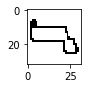

CNN/ANN Predictions:
Symbol_id: 64 , Latex: \delta , Confidence Score: 62.93 %
Symbol_id: 40 , Latex: d , Confidence Score: 35.52 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.07 %


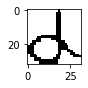

number of char in image: 6
Image path:  research/object_detection/training/test_images\exp0044.png


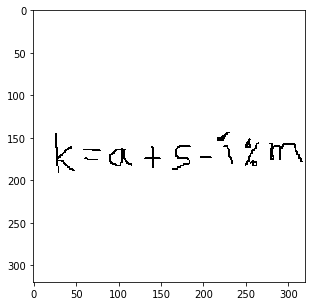

CNN/ANN Predictions:
Symbol_id: 88 , Latex: \& , Confidence Score: 34.93 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 19.35 %
Symbol_id: 22 , Latex: W , Confidence Score: 11.0 %
Symbol_id: 10 , Latex: K , Confidence Score: 9.89 %
Symbol_id: 47 , Latex: k , Confidence Score: 9.06 %
Symbol_id: 58 , Latex: w , Confidence Score: 6.63 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 2.51 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.1 %


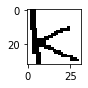

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 64.89 %
Symbol_id: 104 , Latex: = , Confidence Score: 14.8 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 4.09 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.09 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 2.87 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.93 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.76 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.68 %


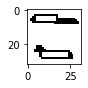

CNN/ANN Predictions:
Symbol_id: 85 , Latex: \$ , Confidence Score: 96.13 %
Symbol_id: 88 , Latex: \& , Confidence Score: 1.9 %


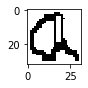

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 61.09 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 12.93 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 7.79 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 7.51 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 4.4 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.85 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.35 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.11 %


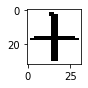

CNN/ANN Predictions:
Symbol_id: 85 , Latex: \$ , Confidence Score: 95.64 %
Symbol_id: 88 , Latex: \& , Confidence Score: 2.04 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.04 %


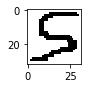

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 39.34 %
Symbol_id: 104 , Latex: = , Confidence Score: 35.7 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 10.09 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.61 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.67 %
Symbol_id: 39 , Latex: c , Confidence Score: 1.4 %


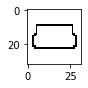

CNN/ANN Predictions:
Symbol_id: 85 , Latex: \$ , Confidence Score: 30.51 %
Symbol_id: 55 , Latex: s , Confidence Score: 24.03 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 17.64 %
Symbol_id: 90 , Latex: \% , Confidence Score: 8.77 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 6.81 %
Symbol_id: 53 , Latex: q , Confidence Score: 3.45 %
Symbol_id: 6 , Latex: G , Confidence Score: 2.49 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 1.22 %
Symbol_id: 18 , Latex: S , Confidence Score: 1.15 %


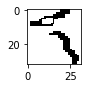

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 98.37 %


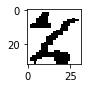

CNN/ANN Predictions:
Symbol_id: 50 , Latex: n , Confidence Score: 78.87 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 15.72 %
Symbol_id: 12 , Latex: M , Confidence Score: 2.71 %


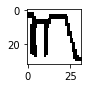

number of char in image: 9
Image path:  research/object_detection/training/test_images\exp0045.png


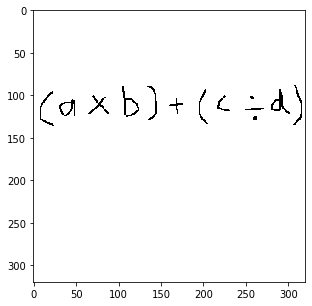

CNN/ANN Predictions:
Symbol_id: 39 , Latex: c , Confidence Score: 24.92 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 22.47 %
Symbol_id: 78 , Latex: < , Confidence Score: 22.42 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 10.04 %
Symbol_id: 2 , Latex: C , Confidence Score: 7.22 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 6.94 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.82 %
Symbol_id: 41 , Latex: e , Confidence Score: 1.35 %


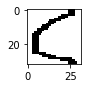

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 70.29 %
Symbol_id: 56 , Latex: u , Confidence Score: 15.51 %
Symbol_id: 89 , Latex: \# , Confidence Score: 7.67 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.3 %
Symbol_id: 37 , Latex: a , Confidence Score: 2.28 %


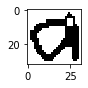

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 98.14 %


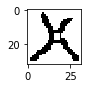

CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 69.84 %
Symbol_id: 44 , Latex: h , Confidence Score: 24.46 %
Symbol_id: 22 , Latex: W , Confidence Score: 1.39 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 1.16 %


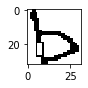

CNN/ANN Predictions:
Symbol_id: 79 , Latex: > , Confidence Score: 26.93 %
Symbol_id: 9 , Latex: J , Confidence Score: 24.99 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 22.33 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 9.23 %
Symbol_id: 60 , Latex: y , Confidence Score: 8.18 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 4.7 %


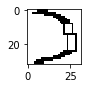

CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 75.12 %
Symbol_id: 89 , Latex: \# , Confidence Score: 11.14 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 8.17 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 2.79 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.07 %


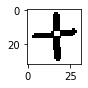

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 45.46 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 42.66 %
Symbol_id: 78 , Latex: < , Confidence Score: 4.83 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.85 %
Symbol_id: 39 , Latex: c , Confidence Score: 1.26 %


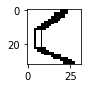

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 83.12 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 6.37 %
Symbol_id: 78 , Latex: < , Confidence Score: 3.62 %
Symbol_id: 32 , Latex: 6 , Confidence Score: 2.29 %


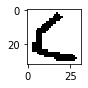

CNN/ANN Predictions:
Symbol_id: 56 , Latex: u , Confidence Score: 26.82 %
Symbol_id: 58 , Latex: w , Confidence Score: 14.07 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 12.67 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 11.75 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 10.14 %
Symbol_id: 40 , Latex: d , Confidence Score: 9.73 %
Symbol_id: 7 , Latex: H , Confidence Score: 2.51 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.64 %
Symbol_id: 20 , Latex: U , Confidence Score: 1.6 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.25 %
Symbol_id: 0 , Latex: A , Confidence Score: 1.11 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 1.04 %


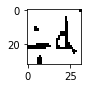

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 48.9 %
Symbol_id: 43 , Latex: g , Confidence Score: 26.34 %
Symbol_id: 60 , Latex: y , Confidence Score: 9.69 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.78 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.76 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 1.55 %
Symbol_id: 26 , Latex: 0 , Confidence Score: 1.43 %
Symbol_id: 87 , Latex: \} , Confidence Score: 1.24 %
Symbol_id: 9 , Latex: J , Confidence Score: 1.17 %
Symbol_id: 37 , Latex: a , Confidence Score: 1.07 %
Symbol_id: 14 , Latex: O , Confidence Score: 1.05 %


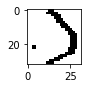

number of char in image: 10
Image path:  research/object_detection/training/test_images\exp0046.png


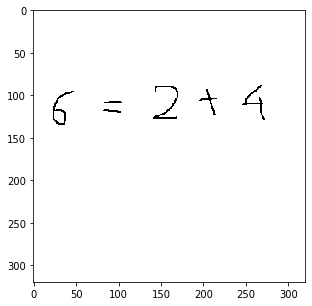

CNN/ANN Predictions:
Symbol_id: 32 , Latex: 6 , Confidence Score: 87.13 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 5.68 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 3.73 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 2.4 %


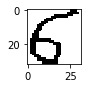

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 76.95 %
Symbol_id: 90 , Latex: \% , Confidence Score: 6.78 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 4.7 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 3.83 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.99 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.97 %


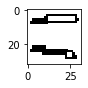

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 98.57 %
Symbol_id: 9 , Latex: J , Confidence Score: 1.22 %


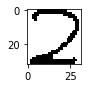

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 89.68 %
Symbol_id: 84 , Latex: + , Confidence Score: 4.22 %
Symbol_id: 53 , Latex: q , Confidence Score: 2.75 %


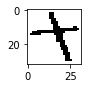

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 83.65 %
Symbol_id: 7 , Latex: H , Confidence Score: 5.76 %
Symbol_id: 89 , Latex: \# , Confidence Score: 4.43 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 2.73 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.08 %


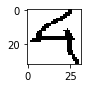

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0047.png


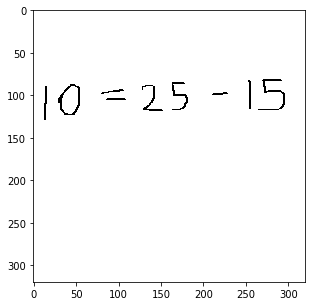

CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 23.51 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 18.25 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 12.11 %
Symbol_id: 9 , Latex: J , Confidence Score: 7.89 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 5.17 %
Symbol_id: 26 , Latex: 0 , Confidence Score: 5.07 %
Symbol_id: 14 , Latex: O , Confidence Score: 4.17 %
Symbol_id: 99 , Latex: [ , Confidence Score: 3.91 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 3.58 %
Symbol_id: 100 , Latex: ] , Confidence Score: 3.5 %
Symbol_id: 8 , Latex: I , Confidence Score: 2.12 %
Symbol_id: 4 , Latex: E , Confidence Score: 1.79 %
Symbol_id: 46 , Latex: j , Confidence Score: 1.62 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.08 %


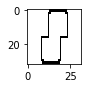

CNN/ANN Predictions:
Symbol_id: 14 , Latex: O , Confidence Score: 56.76 %
Symbol_id: 26 , Latex: 0 , Confidence Score: 32.85 %
Symbol_id: 51 , Latex: o , Confidence Score: 6.1 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 2.51 %


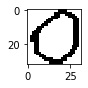

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 49.48 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 44.11 %
Symbol_id: 104 , Latex: = , Confidence Score: 1.57 %


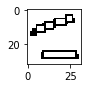

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 60.25 %
Symbol_id: 25 , Latex: Z , Confidence Score: 10.81 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 9.48 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 9.04 %
Symbol_id: 61 , Latex: z , Confidence Score: 7.86 %


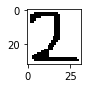

CNN/ANN Predictions:
Symbol_id: 1 , Latex: B , Confidence Score: 71.19 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 25.96 %
Symbol_id: 35 , Latex: 9 , Confidence Score: 1.06 %


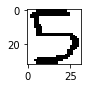

CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 45.57 %
Symbol_id: 94 , Latex: \div , Confidence Score: 19.48 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 4.05 %
Symbol_id: 105 , Latex: //( , Confidence Score: 3.49 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 3.38 %
Symbol_id: 79 , Latex: > , Confidence Score: 3.12 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 2.43 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.99 %
Symbol_id: 91 , Latex: \cup , Confidence Score: 1.98 %
Symbol_id: 95 , Latex: \cap , Confidence Score: 1.91 %
Symbol_id: 57 , Latex: v , Confidence Score: 1.4 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 1.29 %
Symbol_id: 78 , Latex: < , Confidence Score: 1.12 %


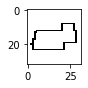

CNN/ANN Predictions:
Symbol_id: 98 , Latex: \exists , Confidence Score: 48.82 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 30.82 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 8.35 %
Symbol_id: 55 , Latex: s , Confidence Score: 2.33 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 2.2 %
Symbol_id: 8 , Latex: I , Confidence Score: 1.34 %


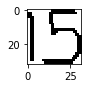

number of char in image: 7
Image path:  research/object_detection/training/test_images\exp0048.png


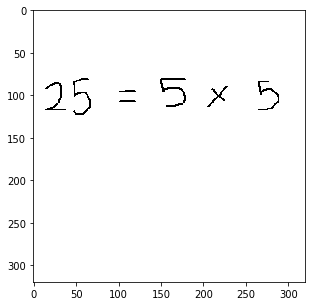

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 91.35 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 2.05 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 1.76 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 1.46 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.27 %


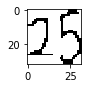

CNN/ANN Predictions:
Symbol_id: 81 , Latex: \supset , Confidence Score: 25.01 %
Symbol_id: 90 , Latex: \% , Confidence Score: 20.26 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 20.12 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 8.93 %
Symbol_id: 104 , Latex: = , Confidence Score: 8.92 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 7.13 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 3.28 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 1.98 %


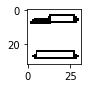

CNN/ANN Predictions:
Symbol_id: 31 , Latex: 5 , Confidence Score: 83.22 %
Symbol_id: 1 , Latex: B , Confidence Score: 8.95 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 3.22 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.44 %


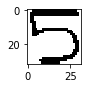

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 91.32 %
Symbol_id: 92 , Latex: \times , Confidence Score: 8.38 %


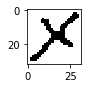

CNN/ANN Predictions:
Symbol_id: 1 , Latex: B , Confidence Score: 65.14 %
Symbol_id: 3 , Latex: D , Confidence Score: 19.09 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 13.12 %


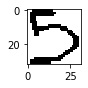

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0049.png


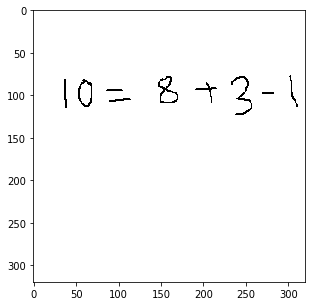

CNN/ANN Predictions:
Symbol_id: 100 , Latex: ] , Confidence Score: 94.13 %
Symbol_id: 8 , Latex: I , Confidence Score: 2.03 %
Symbol_id: 86 , Latex: \{ , Confidence Score: 1.06 %


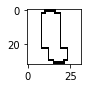

CNN/ANN Predictions:
Symbol_id: 14 , Latex: O , Confidence Score: 48.86 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 22.43 %
Symbol_id: 26 , Latex: 0 , Confidence Score: 12.94 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 11.65 %
Symbol_id: 51 , Latex: o , Confidence Score: 1.75 %


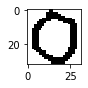

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 99.47 %


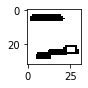

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 79.91 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 10.25 %
Symbol_id: 0 , Latex: A , Confidence Score: 3.25 %
Symbol_id: 90 , Latex: \% , Confidence Score: 3.05 %
Symbol_id: 17 , Latex: R , Confidence Score: 1.17 %


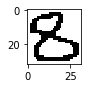

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 61.01 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 11.36 %
Symbol_id: 43 , Latex: g , Confidence Score: 7.76 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 5.11 %
Symbol_id: 89 , Latex: \# , Confidence Score: 2.69 %
Symbol_id: 53 , Latex: q , Confidence Score: 1.98 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 1.33 %


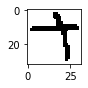

CNN/ANN Predictions:
Symbol_id: 29 , Latex: 3 , Confidence Score: 98.59 %


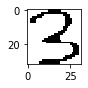

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 39.34 %
Symbol_id: 104 , Latex: = , Confidence Score: 35.7 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 10.09 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 4.61 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 2.67 %
Symbol_id: 39 , Latex: c , Confidence Score: 1.4 %


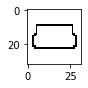

CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 73.58 %
Symbol_id: 88 , Latex: \& , Confidence Score: 21.93 %
Symbol_id: 10 , Latex: K , Confidence Score: 2.04 %


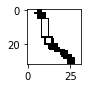

number of char in image: 8
Image path:  research/object_detection/training/test_images\exp0050.png


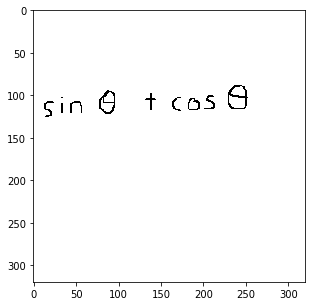

CNN/ANN Predictions:
Symbol_id: 102 , Latex: \infty , Confidence Score: 99.85 %


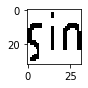

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 97.41 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 1.16 %


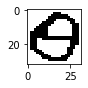

CNN/ANN Predictions:
Symbol_id: 73 , Latex: \phi , Confidence Score: 50.13 %
Symbol_id: 84 , Latex: + , Confidence Score: 21.47 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 13.32 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 11.24 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.06 %


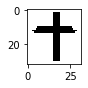

CNN/ANN Predictions:
Symbol_id: 74 , Latex: \omega , Confidence Score: 99.06 %


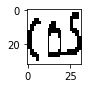

CNN/ANN Predictions:
Symbol_id: 67 , Latex: \theta , Confidence Score: 99.71 %


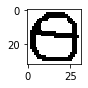

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0051.png


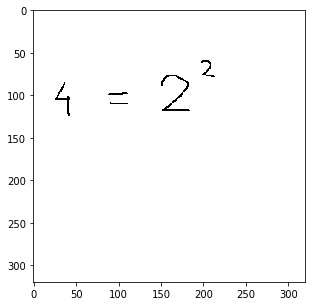

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 55.61 %
Symbol_id: 67 , Latex: \theta , Confidence Score: 11.87 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 9.85 %
Symbol_id: 53 , Latex: q , Confidence Score: 9.1 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 2.85 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 2.74 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.26 %
Symbol_id: 12 , Latex: M , Confidence Score: 1.03 %


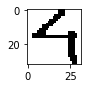

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 40.87 %
Symbol_id: 104 , Latex: = , Confidence Score: 23.41 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 16.11 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 8.46 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 3.54 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.63 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 1.22 %


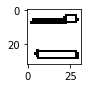

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 96.37 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 1.18 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.13 %


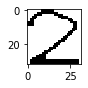

CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 88.2 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.56 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 2.38 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 2.34 %
Symbol_id: 37 , Latex: a , Confidence Score: 1.13 %


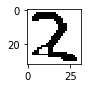

number of char in image: 4
Image path:  research/object_detection/training/test_images\exp0052.png


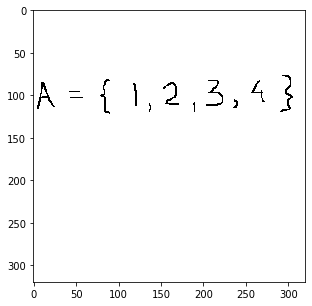

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 62.7 %
Symbol_id: 0 , Latex: A , Confidence Score: 34.58 %


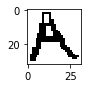

CNN/ANN Predictions:
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 32.61 %
Symbol_id: 90 , Latex: \% , Confidence Score: 30.56 %
Symbol_id: 104 , Latex: = , Confidence Score: 12.16 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 10.15 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 6.99 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.5 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 1.0 %


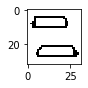

CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 35.19 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 17.09 %
Symbol_id: 88 , Latex: \& , Confidence Score: 9.69 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 8.46 %
Symbol_id: 53 , Latex: q , Confidence Score: 8.05 %
Symbol_id: 66 , Latex: \eta , Confidence Score: 6.3 %
Symbol_id: 30 , Latex: 4 , Confidence Score: 3.67 %
Symbol_id: 78 , Latex: < , Confidence Score: 2.17 %
Symbol_id: 5 , Latex: F , Confidence Score: 1.48 %


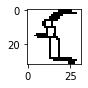

CNN/ANN Predictions:
Symbol_id: 66 , Latex: \eta , Confidence Score: 92.69 %
Symbol_id: 27 , Latex: 1 , Confidence Score: 2.63 %


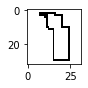

CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 62.83 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 10.73 %
Symbol_id: 73 , Latex: \phi , Confidence Score: 5.75 %
Symbol_id: 106 , Latex: //) , Confidence Score: 3.77 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 3.09 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.95 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.75 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.51 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.02 %


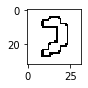

CNN/ANN Predictions:
Symbol_id: 28 , Latex: 2 , Confidence Score: 62.28 %
Symbol_id: 90 , Latex: \% , Confidence Score: 31.29 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.16 %


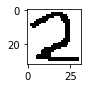

CNN/ANN Predictions:
Symbol_id: 27 , Latex: 1 , Confidence Score: 30.35 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 13.93 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 11.72 %
Symbol_id: 105 , Latex: //( , Confidence Score: 11.54 %
Symbol_id: 48 , Latex: l , Confidence Score: 7.76 %
Symbol_id: 21 , Latex: V , Confidence Score: 7.49 %
Symbol_id: 106 , Latex: //) , Confidence Score: 3.94 %
Symbol_id: 76 , Latex: \leq , Confidence Score: 3.87 %
Symbol_id: 57 , Latex: v , Confidence Score: 2.0 %
Symbol_id: 24 , Latex: Y , Confidence Score: 1.72 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.14 %


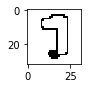

CNN/ANN Predictions:
Symbol_id: 29 , Latex: 3 , Confidence Score: 58.35 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 13.78 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 6.84 %
Symbol_id: 0 , Latex: A , Confidence Score: 6.03 %
Symbol_id: 53 , Latex: q , Confidence Score: 3.54 %
Symbol_id: 61 , Latex: z , Confidence Score: 1.78 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 1.73 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.27 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.14 %


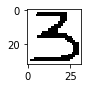

CNN/ANN Predictions:
Symbol_id: 77 , Latex: \geq , Confidence Score: 53.29 %
Symbol_id: 104 , Latex: = , Confidence Score: 33.16 %
Symbol_id: 106 , Latex: //) , Confidence Score: 2.78 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 1.88 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 1.77 %
Symbol_id: 79 , Latex: > , Confidence Score: 1.77 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 1.31 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.08 %


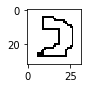

CNN/ANN Predictions:
Symbol_id: 30 , Latex: 4 , Confidence Score: 61.45 %
Symbol_id: 0 , Latex: A , Confidence Score: 36.13 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.12 %


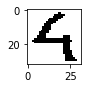

CNN/ANN Predictions:
Symbol_id: 87 , Latex: \} , Confidence Score: 68.28 %
Symbol_id: 29 , Latex: 3 , Confidence Score: 10.98 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 8.45 %
Symbol_id: 88 , Latex: \& , Confidence Score: 5.22 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.38 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.08 %


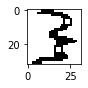

number of char in image: 11
Image path:  research/object_detection/training/test_images\exp0053.png


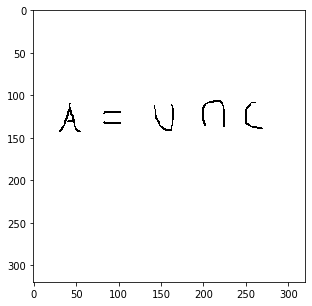

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 78.63 %
Symbol_id: 69 , Latex: \lambda , Confidence Score: 9.02 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 5.22 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 4.28 %


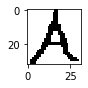

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 83.38 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 5.9 %
Symbol_id: 25 , Latex: Z , Confidence Score: 3.87 %
Symbol_id: 90 , Latex: \% , Confidence Score: 1.81 %
Symbol_id: 85 , Latex: \$ , Confidence Score: 1.23 %


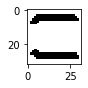

CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 62.06 %
Symbol_id: 22 , Latex: W , Confidence Score: 21.51 %
Symbol_id: 56 , Latex: u , Confidence Score: 9.37 %
Symbol_id: 20 , Latex: U , Confidence Score: 2.62 %
Symbol_id: 57 , Latex: v , Confidence Score: 2.58 %


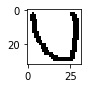

CNN/ANN Predictions:
Symbol_id: 95 , Latex: \cap , Confidence Score: 82.7 %
Symbol_id: 50 , Latex: n , Confidence Score: 11.26 %
Symbol_id: 51 , Latex: o , Confidence Score: 5.34 %


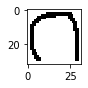

CNN/ANN Predictions:
Symbol_id: 80 , Latex: \subset , Confidence Score: 84.75 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 3.5 %
Symbol_id: 62 , Latex: \Sigma , Confidence Score: 2.41 %
Symbol_id: 105 , Latex: //( , Confidence Score: 1.95 %
Symbol_id: 2 , Latex: C , Confidence Score: 1.32 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 1.27 %
Symbol_id: 39 , Latex: c , Confidence Score: 1.12 %


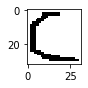

number of char in image: 5
Image path:  research/object_detection/training/test_images\exp0054.png


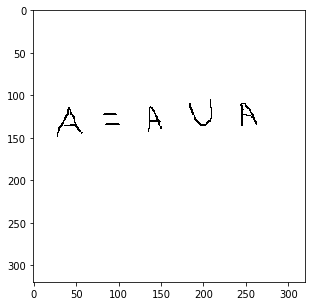

CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 98.4 %


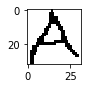

CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 64.34 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 18.27 %
Symbol_id: 104 , Latex: = , Confidence Score: 9.68 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 4.59 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.28 %


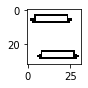

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 35.8 %
Symbol_id: 0 , Latex: A , Confidence Score: 23.89 %
Symbol_id: 89 , Latex: \# , Confidence Score: 23.08 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 13.65 %
Symbol_id: 13 , Latex: N , Confidence Score: 1.02 %


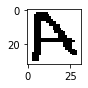

CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 92.78 %
Symbol_id: 20 , Latex: U , Confidence Score: 3.45 %
Symbol_id: 56 , Latex: u , Confidence Score: 1.71 %


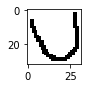

CNN/ANN Predictions:
Symbol_id: 93 , Latex: \ast , Confidence Score: 77.04 %
Symbol_id: 0 , Latex: A , Confidence Score: 16.51 %
Symbol_id: 89 , Latex: \# , Confidence Score: 3.11 %
Symbol_id: 7 , Latex: H , Confidence Score: 1.46 %


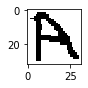

number of char in image: 5


In [71]:
for i in TEST_IMAGE_PATHS:
    image = cv2.imread(i)
    print('Image path: ', i)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res,thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY_INV) #threshold 
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)) 
    dilated = cv2.dilate(thresh,kernel,iterations = 5) 
    val,contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 
    coord = []
    for contour in contours:  
        [x,y,w,h] = cv2.boundingRect(contour)   
        if h>300 and w>300:   
            continue   
        if h<7 or w<7:   
            continue  
        coord.append((x,y,w,h)) 
    coord.sort(key=lambda tup:tup[0]) # if the image has only one sentence sort in one axis
    count = 0
    for cor in coord:
        [x,y,w,h] = cor
        t = image[y:y+h,x:x+w,:]
        t = remove_wspaces(t)
        t = cv2.resize(t, (32,32))
        
        # convert to a binary array (contains either 1 or 0)
        _, t = cv2.threshold(t,200,255,cv2.THRESH_BINARY)
        
        # edge detection to remove noise
        t = cv2.Laplacian(t,cv2.CV_64F, ksize=3)
        
        
        
        # fill any gaps inside feature lost during edge detection
        kernel = np.ones((3,3),np.uint8)
        t = cv2.morphologyEx(t, cv2.MORPH_CLOSE, kernel)
        #
        
        # Erosion area (output is too thin (around 1 px)) 
        #kernel = np.ones((2,2),np.uint8)
        #t = cv2.erode(t,kernel,iterations = 1)
        #
        
        t = 255 - t
        
        # this line is used to reset all values to 0 or 255
        _, t = cv2.threshold(t,50,255,cv2.THRESH_BINARY)
                
        # Predict label for cropped image with CNN
        t_im = np.asarray(t).astype('uint8')
        #t_im = cv2.cvtColor(t_im, cv2.COLOR_BGRA2RGBA)
        #t_im = cv2.cvtColor(t_im, cv2.COLOR_RGBA2RGB)
        #t_im = cv2.cvtColor(t_im, cv2.COLOR_BGR2RGB)
        t_im = cv2.cvtColor(t_im, cv2.COLOR_RGB2GRAY)
        t_im = cv2.resize(t_im, (32,32))
        t_im = t_im / 255.0
        
        # Symbol Prediction
        # CNN
        t_im = np.resize(t_im, (1, 1, 32, 32))
        t_im = t_im.astype('float32')
        res = cnn.predict(t_im)
        #
        # ANN
        #t_im = t_im.flatten().reshape((1, 32*32))
        #print(t_im.shape)
        #res = ann.predict(t_im)
        #
        res = res.flatten()
        # lbl = one_hot_encode_to_char(res, threshold=0.1)
        # if type(lbl) == list: lbl = lbl[0]
        # print("Symbol is :", symbols.loc[symbols['new_id']==lbl])
        lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
        print("CNN/ANN Predictions:")
        for j in lbls:
            symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
            latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
            print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', round(j[1]*100, 2), '%')

        
        # Print figure
        plt.figure(figsize=(1,1))
        
        # plt.subplot(len(coord),1, count+1)
        plt.imshow(t.astype('uint8'))
        plt.show()
        count += 1
    print("number of char in image:", count)